In [ ]:

!pip install diffusers controlnet-aux transformers accelerate safetensors

# Imports
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from controlnet_aux import MidasDetector
import torch
from PIL import Image
import os
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load ControlNet Depth Model
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-depth",
    torch_dtype=torch.float16 if device=="cuda" else torch.float32
)

# Load Stable Diffusion Pipeline
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch.float16 if device=="cuda" else torch.float32
).to(device)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Load Midas Depth Estimator
depth_estimator = MidasDetector.from_pretrained("lllyasviel/ControlNet").to(device)



Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [8]:
# Input and Output folders
input_folder = "D:\\college\\imp-doc\\sem6\\GENAI\\project\\new\\image"
output_folder = "output_images"
os.makedirs(output_folder, exist_ok=True)

# Process all images
for filename in tqdm(os.listdir(input_folder)):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(input_folder, filename)
        input_image = Image.open(image_path).convert("RGB")

        # Generate Depth Map
        depth_map = depth_estimator(input_image)
        depth_map = depth_map.resize(input_image.size)

        # Prompt for generation
        prompt = "highly detailed, same object but from a different angle, different perspective, realistic DSLR photo"

        # Generate new view
        output = pipe(prompt=prompt, image=depth_map, num_inference_steps=30).images[0]

        # Save Outputs
        output.save(os.path.join(output_folder, f"output_{filename}"))
        depth_map.save(os.path.join(output_folder, f"depth_{filename}"))

print("Done! Check the output_images folder.")


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 1/1 [35:30<00:00, 2130.11s/it]

Done! Check the output_images folder.


In [8]:
import cv2
import numpy as np
import open3d as o3d

# Load RGB and Depth images
rgb = cv2.imread("D:\\college\\imp-doc\\sem6\\GENAI\\project\\3D-Reconstruction-of-Monuments\\output_images\\1002.jpg")
depth = cv2.imread("D:\\college\\imp-doc\\sem6\\GENAI\\project\\3D-Reconstruction-of-Monuments\\output_images\\depth_1002.jpg", cv2.IMREAD_UNCHANGED)

# If depth is 3-channel (accidentally), convert to 1-channel grayscale
if len(depth.shape) == 3:
    depth = cv2.cvtColor(depth, cv2.COLOR_BGR2GRAY)

# Apply bilateral filter to smooth the depth
depth = cv2.bilateralFilter(depth, d=5, sigmaColor=75, sigmaSpace=75)

# Camera Intrinsics
fx = 615.426
fy = 615.426
cx = 312.500
cy = 249.500

# Depth scale – adjust based on your data
depth_scale = 5.0 / 254  # Or 0.001 if depth is in mm

points = []
colors = []

height, width = depth.shape

for v in range(height):
    for u in range(width):
        d = depth[v, u]
        Z = d * depth_scale

        if Z < 0.1 or Z > 5.0:
            continue

        X = (u - cx) * Z / fx
        Y = (v - cy) * Z / fy

        points.append([X, Y, Z])
        colors.append(rgb[v, u] / 255.0)

# Convert to Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.array(points))
pcd.colors = o3d.utility.Vector3dVector(np.array(colors))

# Clean up noise
pcd, _ = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)

# Visualize in Jupyter
o3d.visualization.draw_geometries([pcd])


In [24]:
depth = cv2.imread('D:\\college\\imp-doc\\sem6\\GENAI\\project\\3D-Reconstruction-of-Monuments\\output_images\\depth_1002.jpg', cv2.IMREAD_GRAYSCALE)
print(depth)

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [197 197 197 ... 247 247 247]
 [198 198 198 ... 248 248 248]
 [198 198 198 ... 249 248 248]]


In [25]:
print(depth.min(), depth.max())


0 254


In [3]:
!pip install timm


preprocessor_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

c:\Users\sameer\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\dpt\feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/942 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


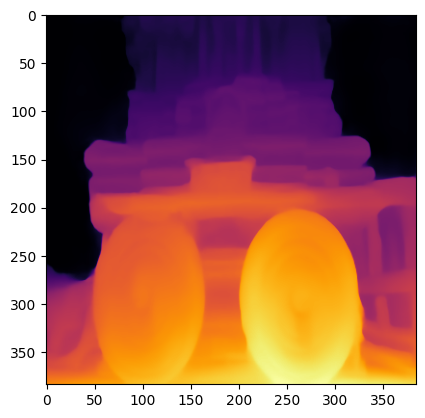

In [4]:
import torch
import torchvision.transforms as T
from PIL import Image
import urllib
import matplotlib.pyplot as plt
from transformers import DPTFeatureExtractor, DPTForDepthEstimation

image = Image.open("D:\\college\\imp-doc\\sem6\\GENAI\\project\\3D-Reconstruction-of-Monuments\\output_images\\1002.jpg")
extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-large")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")

inputs = extractor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth.squeeze().cpu().numpy()

# Normalize and visualize
depth_min = predicted_depth.min()
depth_max = predicted_depth.max()
depth_vis = (predicted_depth - depth_min) / (depth_max - depth_min)
plt.imshow(depth_vis, cmap="inferno")
plt.show()
